In [96]:
import threading

# Helper thread to avoid the Spark StreamingContext from blocking Jupyter
        
class StreamingThread(threading.Thread):
    def __init__(self, ssc):
        super().__init__()
        self.ssc = ssc
    def run(self):
        self.ssc.start()
        self.ssc.awaitTermination()
    def stop(self):
        print('----- Stopping... this may take a few seconds -----')
        self.ssc.stop(stopSparkContext=False, stopGraceFully=True)

In [97]:
sc

<SparkContext master=local[2] appName=PySparkShell>

In [3]:
import os
from pyspark.streaming import StreamingContext

In [4]:
# Save less frequently and create less subdirectories. I.e. every 120 seconds
ssc = StreamingContext(sc, 120)

/Users/stantschal/Desktop/spark/spark-3.5.1-bin-hadoop3/python/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


In [5]:
lines = ssc.socketTextStream("seppe.net", 7778)

In [6]:
out_dir = f"{os.path.abspath('')}{os.path.sep}saved_stories"
lines.repartition(1).saveAsTextFiles(f"file:///{out_dir}")
print("Saving to", out_dir)

Saving to /Users/stantschal/Desktop/spark/notebooks/saved_stories


In [7]:
ssc_t = StreamingThread(ssc)
ssc_t.start()

24/05/05 09:19:16 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/05 09:19:16 WARN BlockManager: Block input-0-1714889956400 replicated to only 0 peer(s) instead of 1 peers
24/05/05 09:19:20 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/05 09:19:20 WARN BlockManager: Block input-0-1714889960600 replicated to only 0 peer(s) instead of 1 peers
24/05/05 09:19:22 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/05 09:19:22 WARN BlockManager: Block input-0-1714889962600 replicated to only 0 peer(s) instead of 1 peers
24/05/05 09:19:23 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/05 09:19:23 WARN BlockManager: Block input-0-1714889963600 replicated to only 0 peer(s) instead of 1 peers
24/05/05 09:19:24 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/05 09:19:24 WARN BlockManager: Block input-0-1714889964600 replicated to

In [8]:
# Don't run this cell unless you want to stop. You should see subdirectories appear in the out_dir
ssc_t.stop()

----- Stopping... this may take a few seconds -----


24/05/05 10:26:46 WARN SocketReceiver: Error receiving data
java.net.SocketException: Socket closed
	at java.base/java.net.SocketInputStream.socketRead0(Native Method)
	at java.base/java.net.SocketInputStream.socketRead(SocketInputStream.java:115)
	at java.base/java.net.SocketInputStream.read(SocketInputStream.java:168)
	at java.base/java.net.SocketInputStream.read(SocketInputStream.java:140)
	at java.base/sun.nio.cs.StreamDecoder.readBytes(StreamDecoder.java:284)
	at java.base/sun.nio.cs.StreamDecoder.implRead(StreamDecoder.java:326)
	at java.base/sun.nio.cs.StreamDecoder.read(StreamDecoder.java:178)
	at java.base/java.io.InputStreamReader.read(InputStreamReader.java:181)
	at java.base/java.io.BufferedReader.fill(BufferedReader.java:161)
	at java.base/java.io.BufferedReader.readLine(BufferedReader.java:326)
	at java.base/java.io.BufferedReader.readLine(BufferedReader.java:392)
	at org.apache.spark.streaming.dstream.SocketReceiver$$anon$2.getNext(SocketInputDStream.scala:121)
	at org.a

In [156]:
#base_dir = "/Users/stantschal/Desktop/spark/notebooks/saved_stories"

In [157]:
#def find_json_files(base_dir):
#    json_files = []
#    for root, dirs, files in os.walk(base_dir):
#        for file in files:
#            if file.startswith("part"):
#                json_files.append(os.path.join(root, file))
#    return json_files

In [158]:
#json_files = find_json_files(base_dir)

In [ ]:
#df.to_json("/Users/stantschal/Desktop/spark/notebooks/all_files.json", orient="records")

In [166]:
df = spark.read.json("/Users/stantschal/Desktop/spark/notebooks/all_files.json")

In [167]:
df.count()

3452

In [6]:
from pyspark.sql.functions import col, count
grouped_df = df.groupBy("aid").agg(count("aid").alias("count"))
duplicates_df = grouped_df.filter(col("count") > 1)

In [7]:
duplicates_df.count()

380

In [8]:
df = df.dropDuplicates(["aid"])

In [9]:
df.count()

3072

In [10]:
df.printSchema()

root
 |-- aid: string (nullable = true)
 |-- comments: long (nullable = true)
 |-- domain: string (nullable = true)
 |-- frontpage: boolean (nullable = true)
 |-- posted_at: string (nullable = true)
 |-- source_text: string (nullable = true)
 |-- source_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- user: string (nullable = true)
 |-- votes: long (nullable = true)



In [11]:
df = df.toPandas()

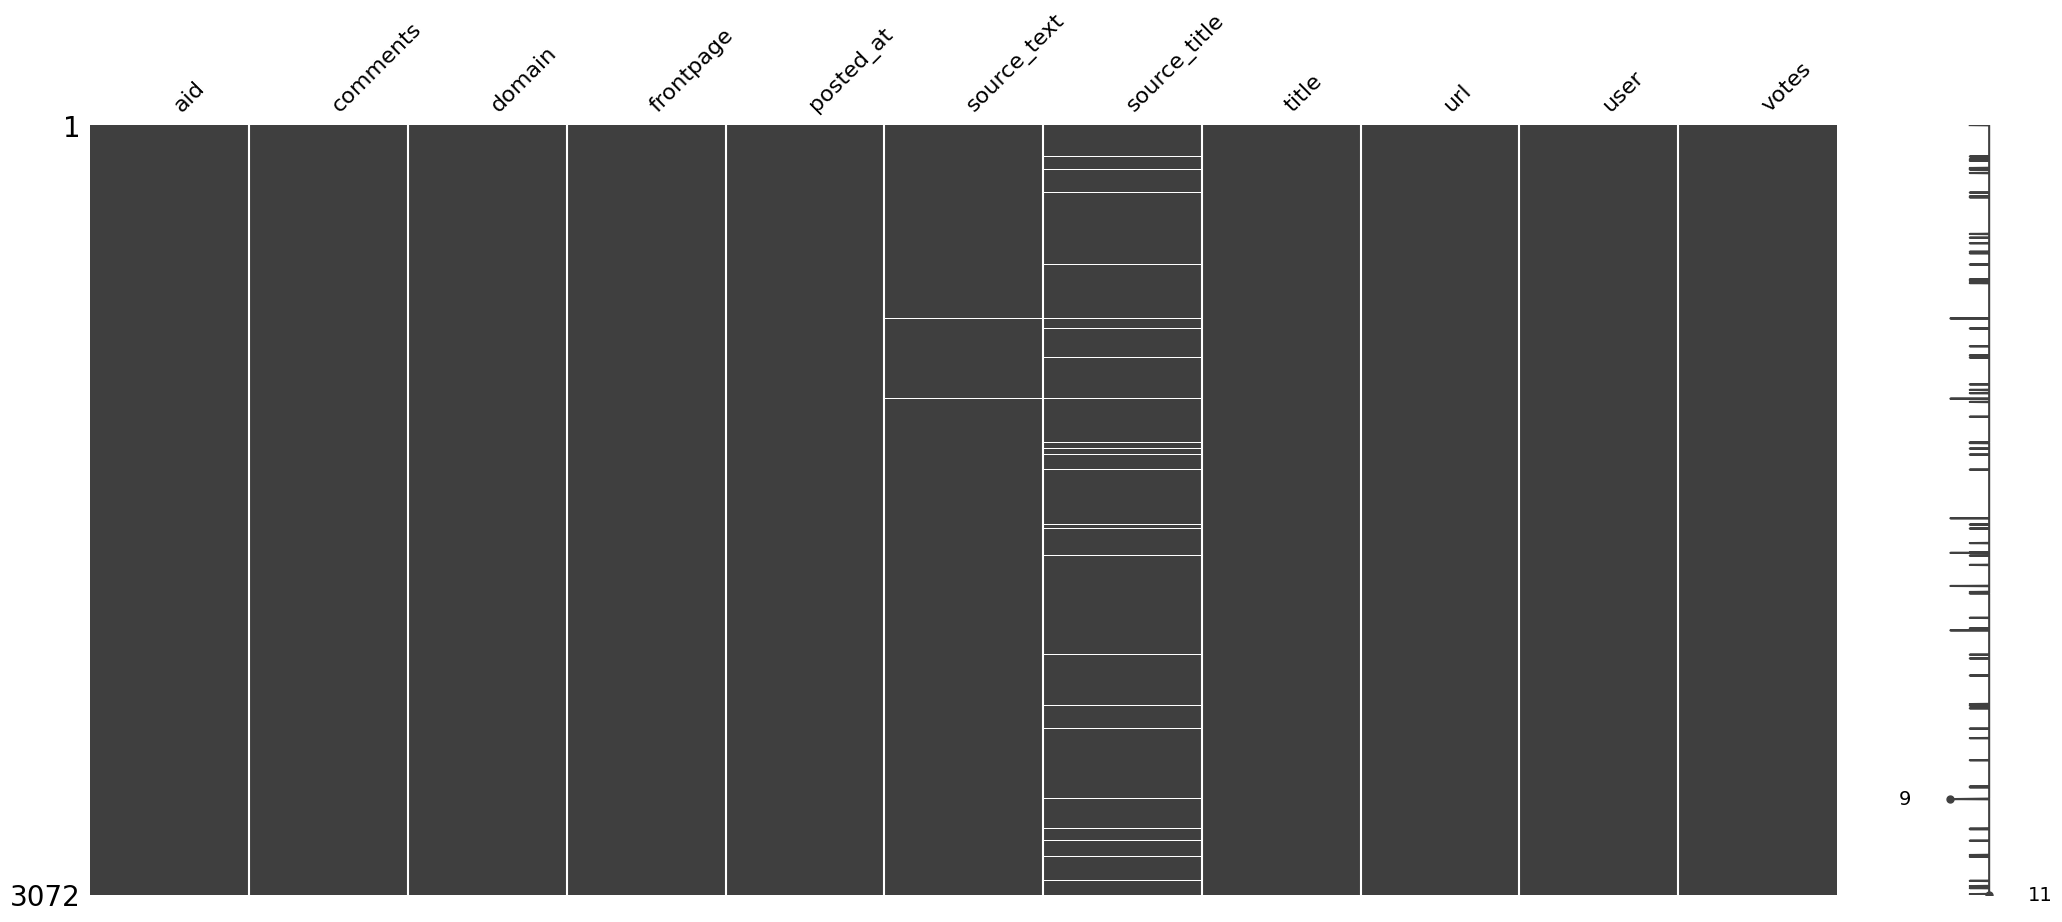

In [12]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df)
plt.show()

In [13]:
#drop entire rows with na values
df = df.dropna()

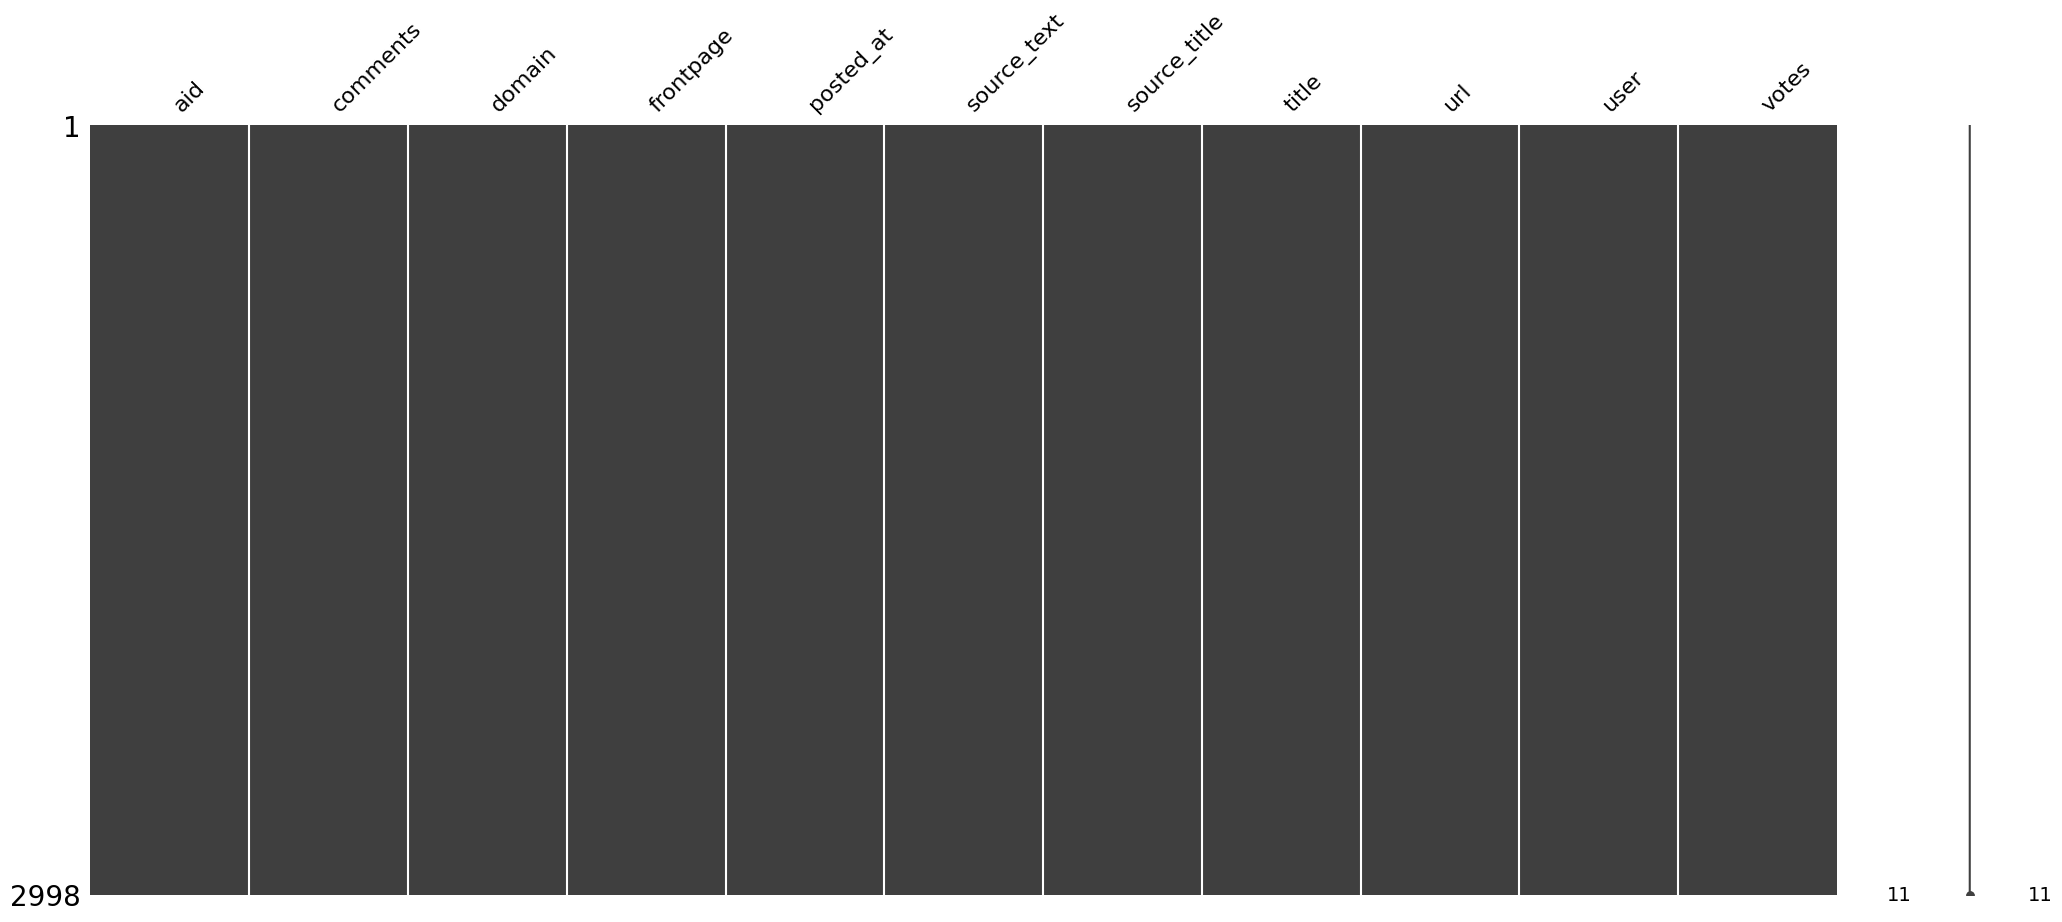

In [14]:
msno.matrix(df)
plt.show()

In [15]:
df.count()

aid             2998
comments        2998
domain          2998
frontpage       2998
posted_at       2998
source_text     2998
source_title    2998
title           2998
url             2998
user            2998
votes           2998
dtype: int64

In [16]:
#find entries with 403 Forbidden and remove them from the dataset
mask = df['source_text'].str.contains("403 Forbidden", case=False) | df['source_title'].str.contains("403 Forbidden", case=False)

In [17]:
rows_to_remove = df[mask]

In [18]:
rows_to_remove.shape

(10, 11)

In [19]:
rows_to_remove.head()

,aid,comments,domain,frontpage,posted_at,source_text,source_title,title,url,user,votes
12,39988522,0,sardinasystems.com,False,2024-04-10 09:01:30,403 Forbidden\n\n# 403 Forbidden\n\nnginx\n\n,403 Forbidden,Join the Webinar on Winning Cloud Migration Ta...,https://www.sardinasystems.com/migrate-from-vm...,SardinaSystems,1
138,40010332,6,poast.org,True,2024-04-12 07:53:42,403 Forbidden\n\n# 403 Forbidden\n\nnginx\n\n,403 Forbidden,Explaining Llm.c in Layman Terms,https://nitter.poast.org/karpathy/status/17781...,publius_0xf3,25
389,40071789,0,artificial-gravity.com,False,2024-04-18 00:46:17,403 Forbidden\n\n403 Forbidden\n\nPlease forwa...,403 Forbidden,SpinCalc: An artificial-gravity calculator in ...,https://www.artificial-gravity.com/sw/SpinCalc/,delichon,1
442,40073202,0,jacobfilipp.com,False,2024-04-18 05:16:53,403 Forbidden\n\n# 403\n\n## Forbidden\n\nAcce...,403 Forbidden,A place I've never been to. A place I'll never go,https://jacobfilipp.com/place/,jfil,1
448,40073394,2,dedoimedo.com,False,2024-04-18 06:02:51,403 Forbidden\n\n# Forbidden\n\nYou don't have...,403 Forbidden,"Wayland, where are we in 2024? Any good for be...",https://www.dedoimedo.com/computers/wayland-20...,jandeboevrie,2


In [20]:
#remove 403 error rows
df = df[~mask]

In [21]:
df.count()

aid             2988
comments        2988
domain          2988
frontpage       2988
posted_at       2988
source_text     2988
source_title    2988
title           2988
url             2988
user            2988
votes           2988
dtype: int64

In [22]:
#detect if the the language of the title is not in english and collect only those ones that are
from langdetect import detect, LangDetectException

def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

df['is_english'] = df['title'].apply(is_english)

df = df[df['is_english']]

df = df.drop(columns=['is_english'])

In [23]:
df.shape

(2728, 11)

In [24]:
#lemmatize the source text and title into separate columns. Values stored as a lists.
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    
    text = re.sub(r'\\n', ' ', text)
    
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text.lower())
    
    filtered_tokens = [t for t in tokens if t not in stop_words]
    
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    
    return lemmatized_tokens

df['clean_source_text'] = df['source_text'].apply(clean_text)

df['clean_source_title'] = df['title'].apply(clean_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stantschal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stantschal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stantschal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/stantschal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
#count the number of words from clean_source_text
def count_words(word_list):
    return len(word_list)
    
df['word_count'] = df['clean_source_text'].apply(count_words)

In [26]:
#collect only the domain name
from urllib.parse import urlparse

def extract_domain(url):
    if not url.startswith(("http://", "https://")):
        url = "http://" + url
    parsed_url = urlparse(url)
    if not parsed_url.netloc:
        return "Invalid URL"
    domain_parts = parsed_url.netloc.split('.')
    main_domain = domain_parts[-2] if len(domain_parts) > 1 else domain_parts[0]
    
    return main_domain

df['domain_name'] = df['domain'].apply(extract_domain)

In [27]:
df.head()

,aid,comments,domain,frontpage,posted_at,source_text,source_title,title,url,user,votes,clean_source_text,clean_source_title,word_count,domain_name
1,39988400,0,acm.org,False,2024-04-10 08:44:24,Wigderson Named Turing Awardee for Decisive Wo...,Wigderson Named Turing Awardee for Decisive Wo...,Wigderson receives Turing Award for contributi...,https://cacm.acm.org/news/wigderson-named-turi...,chmaynard,1,"[wigderson, named, turing, awardee, decisive, ...","[wigderson, receives, turing, award, contribut...",415,acm
2,39988404,0,medium.com/pythoneers,False,2024-04-10 08:45:02,Just a moment...\n\n# medium.com\n\n## Verifyi...,Just a moment...,The Definitive Guide to LLM Writing Styles,https://medium.com/pythoneers/the-definitive-g...,viktorbezdek,1,"[moment, mediumcom, verifying, human, may, tak...","[definitive, guide, llm, writing, style]",24,medium
3,39988415,0,techcrunch.com,True,2024-04-10 08:46:40,TechCrunch is part of the Yahoo family of bran...,TechCrunch is part of the Yahoo family of brands,Microsoft employees exposed internal passwords...,https://techcrunch.com/2024/04/09/microsoft-em...,croes,3,"[techcrunch, part, yahoo, family, brand]","[microsoft, employee, exposed, internal, passw...",5,techcrunch
4,39988417,0,github.com/mrconter1,False,2024-04-10 08:46:47,GitHub - mrconter1/PullRequestBenchmark: Evalu...,GitHub - mrconter1/PullRequestBenchmark: Evalu...,PullRequestBenchmark Challenge: Can AI Replace...,https://github.com/mrconter1/PullRequestBenchmark,AIReach,1,"[github, mrconter1pullrequestbenchmark, evalua...","[pullrequestbenchmark, challenge, ai, replace,...",708,github
5,39988418,0,acm.org,False,2024-04-10 08:46:47,Specifying the Power and Limitations of Random...,Specifying the Power and Limitations of Random...,Specifying the Power and Limitations of Random...,https://cacm.acm.org/opinion/specifying-the-po...,chmaynard,1,"[specifying, power, limitation, randomness, co...","[specifying, power, limitation, randomness]",976,acm


In [28]:
#split the dataset into 70% train and 30% test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [29]:
train_df.head()

,aid,comments,domain,frontpage,posted_at,source_text,source_title,title,url,user,votes,clean_source_text,clean_source_title,word_count,domain_name
2012,40074351,0,ai-gen.blog,False,2024-04-18 09:18:06,"AI-gen Blog - AI Powered Content, Reimagined b...",Is Reading Your Mind Possible? New AI Research...,Is Reading Your Mind Possible? New AI Research...,https://www.ai-gen.blog/2024/04/is-reading-you...,nowhereai,3,"[aigen, blog, ai, powered, content, reimagined...","[reading, mind, possible, new, ai, research, d...",540,ai-gen
391,40071820,0,ncatlab.org,False,2024-04-18 00:50:22,Standard Conjectures on Algebraic Cycles in nL...,Standard Conjectures on Algebraic Cycles in nLab,Standard Conjectures on Algebraic Cycles,https://ncatlab.org/nlab/show/Standard+Conject...,gone35,1,"[standard, conjecture, algebraic, cycle, nlab,...","[standard, conjecture, algebraic, cycle]",652,ncatlab
2051,40092209,0,nytimes.com,False,2024-04-19 21:38:52,"Daniel C. Dennett, Widely Read and Fiercely De...","Daniel C. Dennett, Widely Read and Fiercely De...","Daniel C. Dennett, Widely Read and Fiercely De...",https://www.nytimes.com/2024/04/19/books/danie...,wjb3,1,"[daniel, c, dennett, widely, read, fiercely, d...","[daniel, c, dennett, widely, read, fiercely, d...",2591,nytimes
1373,40230259,0,venturebeat.com,False,2024-05-01 22:16:07,Just a moment...\n\n# venturebeat.com\n\n## Ve...,Just a moment...,Unity announces another new CEO: ex-Zynga exec...,https://venturebeat.com/games/unity-appoints-e...,doomlaser,2,"[moment, venturebeatcom, verifying, human, may...","[unity, announces, another, new, ceo, exzynga,...",24,venturebeat
2341,40111043,0,spectator.co.uk,False,2024-04-22 02:45:07,Richard Dawkins: in defence of scientific trut...,Richard Dawkins: in defence of scientific truth,Richard Dawkins: in defence of scientific truth,https://www.spectator.co.uk/article/richard-da...,underseacables,2,"[richard, dawkins, defence, scientific, truth,...","[richard, dawkins, defence, scientific, truth]",954,co


In [30]:
test_df.head()

,aid,comments,domain,frontpage,posted_at,source_text,source_title,title,url,user,votes,clean_source_text,clean_source_title,word_count,domain_name
1138,40150143,0,guruwebtools.com,False,2024-04-24 21:48:34,100% Free AI SEO Tools » GuruWebTools.com\n\n ...,100% Free AI SEO Tools,Show HN: Free AI SEO online web tools,https://guruwebtools.com,dewblue,2,"[100, free, ai, seo, tool, guruwebtoolscom, ho...","[show, hn, free, ai, seo, online, web, tool]",6599,guruwebtools
3068,40261475,0,nytimes.com,False,2024-05-05 00:42:10,Opinion | 2024 Was the Year That Broke College...,Opinion | This Is Peak College Admissions Insa...,Peak College Admissions Insanity,https://www.nytimes.com/2024/05/01/opinion/col...,mooreds,2,"[opinion, 2024, year, broke, college, admissio...","[peak, college, admission, insanity]",4672,nytimes
2308,40110170,0,theguardian.com,True,2024-04-21 23:39:53,Louisiana’s flagship university lets oil firms...,Louisiana’s flagship university lets oil firms...,Louisiana's flagship university lets oil firms...,https://www.theguardian.com/us-news/2024/apr/2...,thelastgallon,5,"[louisiana, flagship, university, let, oil, fi...","[louisiana, flagship, university, let, oil, fi...",1244,theguardian
1072,40140396,4,mostlypython.com,True,2024-04-24 03:59:31,Django from first principles\n\nMostly Python\...,Django from first principles,"Building a full Django project, starting with ...",https://www.mostlypython.com/django-from-first...,kqnrnq17r,30,"[django, first, principle, mostly, python, sig...","[building, full, django, project, starting, si...",778,mostlypython
79,39989998,0,bls.gov,False,2024-04-10 12:36:04,Access Denied\n\n# Bureau of Labor Statistics\...,Access Denied,CPI for all items rose 0.4% in March; shelter ...,https://www.bls.gov/news.release/archives/cpi_...,impish9208,3,"[access, denied, bureau, labor, statistic, acc...","[cpi, item, rose, 04, march, shelter, gasoline]",52,bls


# Outliers

In [31]:
train_df.shape

(2182, 15)

In [32]:
from scipy.stats import zscore

train_df['comments_zscore'] = zscore(train_df['comments'])

train_df = train_df[train_df['comments_zscore'].abs() <= 3] 

train_df.drop(columns=['comments_zscore'], inplace=True)

In [33]:
train_df['votes_zscore'] = zscore(train_df['votes'])

train_df = train_df[train_df['votes_zscore'].abs() <= 3] 

train_df.drop(columns=['votes_zscore'], inplace=True)

In [34]:
train_df['word_count_zscore'] = zscore(train_df['word_count'])

train_df = train_df[train_df['word_count_zscore'].abs() <= 3] 

train_df.drop(columns=['word_count_zscore'], inplace=True)

In [35]:
train_df.shape

(2099, 15)

In [36]:
test_df.shape

(546, 15)

In [37]:
test_df['comments_zscore'] = zscore(test_df['comments'])

test_df = test_df[test_df['comments_zscore'].abs() <= 3] 

test_df.drop(columns=['comments_zscore'], inplace=True)

In [38]:
test_df['votes_zscore'] = zscore(test_df['votes'])

test_df = test_df[test_df['votes_zscore'].abs() <= 3] 

test_df.drop(columns=['votes_zscore'], inplace=True)

In [39]:
test_df['word_count_zscore'] = zscore(test_df['word_count'])

test_df = test_df[test_df['word_count_zscore'].abs() <= 3] 

test_df.drop(columns=['word_count_zscore'], inplace=True)

In [40]:
test_df.shape

(526, 15)

# Class Imbalance

In [41]:
count_train_set = train_df['frontpage'].value_counts()

print(count_train_set)

False    1769
True      330
Name: frontpage, dtype: int64


In [42]:
count_test_set = test_df['frontpage'].value_counts()

print(count_test_set)

False    446
True      80
Name: frontpage, dtype: int64


In [43]:
minority_class = count_train_set.idxmin()
majority_class = count_train_set.idxmax()

minority_df = train_df[train_df['frontpage'] == minority_class]
majority_df = train_df[train_df['frontpage'] == majority_class]

In [44]:
oversampled_minority_df = minority_df.sample(n=count_train_set[majority_class], replace=True, random_state=42)

In [45]:
train_df = pd.concat([majority_df, oversampled_minority_df])

In [46]:
train_df['frontpage'].value_counts()

False    1769
True     1769
Name: frontpage, dtype: int64

In [47]:
minority_class = count_test_set.idxmin()
majority_class = count_test_set.idxmax()

minority_df = test_df[test_df['frontpage'] == minority_class]
majority_df = test_df[test_df['frontpage'] == majority_class]

In [48]:
oversampled_minority_df = minority_df.sample(n=count_test_set[majority_class], replace=True, random_state=42)

In [49]:
test_df = pd.concat([majority_df, oversampled_minority_df])

In [50]:
test_df['frontpage'].value_counts()

False    446
True     446
Name: frontpage, dtype: int64

# TF-IDF Scores

In [51]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [52]:
#calculate TF-IDF score for each row and for each word in a row
from sklearn.feature_extraction.text import TfidfVectorizer

train_df['tfidf_source_text'] = train_df['clean_source_text'].apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['tfidf_source_text'])

features = tfidf_vectorizer.get_feature_names_out()

# create a dictionary of TF-IDF scores for each row instead of a matrix
def get_tfidf_dict(row_index):
    row = tfidf_matrix[row_index].toarray()[0]

    tfidf_dict = {features[i]: row[i] for i in range(len(row)) if row[i] > 0}
    return tfidf_dict

train_df['TFIDF_Scores'] = [get_tfidf_dict(i) for i in range(tfidf_matrix.shape[0])]

train_df.head()


,aid,comments,domain,frontpage,posted_at,source_text,source_title,title,url,user,votes,clean_source_text,clean_source_title,word_count,domain_name,tfidf_source_text,TFIDF_Scores
2012,40074351,0,ai-gen.blog,False,2024-04-18 09:18:06,"AI-gen Blog - AI Powered Content, Reimagined b...",Is Reading Your Mind Possible? New AI Research...,Is Reading Your Mind Possible? New AI Research...,https://www.ai-gen.blog/2024/04/is-reading-you...,nowhereai,3,"[aigen, blog, ai, powered, content, reimagined...","[reading, mind, possible, new, ai, research, d...",540,ai-gen,aigen blog ai powered content reimagined human...,"{'11': 0.01657256444457039, '13': 0.0179734072..."
391,40071820,0,ncatlab.org,False,2024-04-18 00:50:22,Standard Conjectures on Algebraic Cycles in nL...,Standard Conjectures on Algebraic Cycles in nLab,Standard Conjectures on Algebraic Cycles,https://ncatlab.org/nlab/show/Standard+Conject...,gone35,1,"[standard, conjecture, algebraic, cycle, nlab,...","[standard, conjecture, algebraic, cycle]",652,ncatlab,standard conjecture algebraic cycle nlab nlab ...,"{'14': 0.004913113157741634, '145234': 0.01644..."
2051,40092209,0,nytimes.com,False,2024-04-19 21:38:52,"Daniel C. Dennett, Widely Read and Fiercely De...","Daniel C. Dennett, Widely Read and Fiercely De...","Daniel C. Dennett, Widely Read and Fiercely De...",https://www.nytimes.com/2024/04/19/books/danie...,wjb3,1,"[daniel, c, dennett, widely, read, fiercely, d...","[daniel, c, dennett, widely, read, fiercely, d...",2591,nytimes,daniel c dennett widely read fiercely debated ...,"{'050week': 0.0093295782345452, '050weeklog': ..."
1373,40230259,0,venturebeat.com,False,2024-05-01 22:16:07,Just a moment...\n\n# venturebeat.com\n\n## Ve...,Just a moment...,Unity announces another new CEO: ex-Zynga exec...,https://venturebeat.com/games/unity-appoints-e...,doomlaser,2,"[moment, venturebeatcom, verifying, human, may...","[unity, announces, another, new, ceo, exzynga,...",24,venturebeat,moment venturebeatcom verifying human may take...,"{'87d3d659eb255c14': 0.2800287836542828, 'clou..."
2341,40111043,0,spectator.co.uk,False,2024-04-22 02:45:07,Richard Dawkins: in defence of scientific trut...,Richard Dawkins: in defence of scientific truth,Richard Dawkins: in defence of scientific truth,https://www.spectator.co.uk/article/richard-da...,underseacables,2,"[richard, dawkins, defence, scientific, truth,...","[richard, dawkins, defence, scientific, truth]",954,co,richard dawkins defence scientific truth spect...,"{'01': 0.016747326405612474, '2013': 0.0163600..."


In [53]:
#test set TF-IDF score
test_df['tfidf_source_text'] = test_df['clean_source_text'].apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(test_df['tfidf_source_text'])

features = tfidf_vectorizer.get_feature_names_out()

# create a dictionary of TF-IDF scores for each row instead of a matrix
def get_tfidf_dict(row_index):
    row = tfidf_matrix[row_index].toarray()[0]
    
    tfidf_dict = {features[i]: row[i] for i in range(len(row)) if row[i] > 0}
    return tfidf_dict

test_df['TFIDF_Scores'] = [get_tfidf_dict(i) for i in range(tfidf_matrix.shape[0])]

test_df.head()


,aid,comments,domain,frontpage,posted_at,source_text,source_title,title,url,user,votes,clean_source_text,clean_source_title,word_count,domain_name,tfidf_source_text,TFIDF_Scores
1138,40150143,0,guruwebtools.com,False,2024-04-24 21:48:34,100% Free AI SEO Tools » GuruWebTools.com\n\n ...,100% Free AI SEO Tools,Show HN: Free AI SEO online web tools,https://guruwebtools.com,dewblue,2,"[100, free, ai, seo, tool, guruwebtoolscom, ho...","[show, hn, free, ai, seo, online, web, tool]",6599,guruwebtools,100 free ai seo tool guruwebtoolscom home blog...,"{'100': 0.0024351725160512597, '120': 0.001480..."
3068,40261475,0,nytimes.com,False,2024-05-05 00:42:10,Opinion | 2024 Was the Year That Broke College...,Opinion | This Is Peak College Admissions Insa...,Peak College Admissions Insanity,https://www.nytimes.com/2024/05/01/opinion/col...,mooreds,2,"[opinion, 2024, year, broke, college, admissio...","[peak, college, admission, insanity]",4672,nytimes,opinion 2024 year broke college admission new ...,"{'100': 0.0038164317406213064, '1001': 0.00886..."
79,39989998,0,bls.gov,False,2024-04-10 12:36:04,Access Denied\n\n# Bureau of Labor Statistics\...,Access Denied,CPI for all items rose 0.4% in March; shelter ...,https://www.bls.gov/news.release/archives/cpi_...,impish9208,3,"[access, denied, bureau, labor, statistic, acc...","[cpi, item, rose, 04, march, shelter, gasoline]",52,bls,access denied bureau labor statistic access de...,{'06c01100217127558003de4be81': 0.225210034171...
2414,40113007,0,talosintelligence.com,False,2024-04-22 10:36:05,What’s the deal with the massive backlog of vu...,What’s the deal with the massive backlog of vu...,What's the deal with the backlog of vulnerabil...,https://blog.talosintelligence.com/nvd-vulnera...,skilled,2,"[whats, deal, massive, backlog, vulnerability,...","[whats, deal, backlog, vulnerability, nvd]",897,talosintelligence,whats deal massive backlog vulnerability nvd c...,"{'0800': 0.06760523212918257, '10': 0.01553280..."
272,40059822,0,lilianweng.github.io,False,2024-04-17 02:33:37,Diffusion Models for Video Generation | Lil'Lo...,Diffusion Models for Video Generation,Diffusion Models for Video Generation,https://lilianweng.github.io/posts/2024-04-12-...,TheAlchemist,2,"[diffusion, model, video, generation, lillog, ...","[diffusion, model, video, generation]",2373,github,diffusion model video generation lillog diffus...,"{'10': 0.00961120365349481, '11': 0.0074001447..."


# Sentiment Score Based On Source Text

In [54]:
train_df['clean_source_text_sentence'] = train_df['clean_source_text'].apply(lambda words: ' '.join(words))

In [55]:
#calculate the sentiment score for each row and then aggregate the scores for each word into one single score - compound score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

train_df['sentiment'] = train_df['clean_source_text_sentence'].apply(lambda sentence: analyzer.polarity_scores(sentence))

In [56]:
train_df['compound_score'] = train_df['sentiment'].apply(lambda x: x['compound'])

In [57]:
train_df.head()

,aid,comments,domain,frontpage,posted_at,source_text,source_title,title,url,user,votes,clean_source_text,clean_source_title,word_count,domain_name,tfidf_source_text,TFIDF_Scores,clean_source_text_sentence,sentiment,compound_score
2012,40074351,0,ai-gen.blog,False,2024-04-18 09:18:06,"AI-gen Blog - AI Powered Content, Reimagined b...",Is Reading Your Mind Possible? New AI Research...,Is Reading Your Mind Possible? New AI Research...,https://www.ai-gen.blog/2024/04/is-reading-you...,nowhereai,3,"[aigen, blog, ai, powered, content, reimagined...","[reading, mind, possible, new, ai, research, d...",540,ai-gen,aigen blog ai powered content reimagined human...,"{'11': 0.01657256444457039, '13': 0.0179734072...",aigen blog ai powered content reimagined human...,"{'neg': 0.033, 'neu': 0.82, 'pos': 0.147, 'com...",0.9957
391,40071820,0,ncatlab.org,False,2024-04-18 00:50:22,Standard Conjectures on Algebraic Cycles in nL...,Standard Conjectures on Algebraic Cycles in nLab,Standard Conjectures on Algebraic Cycles,https://ncatlab.org/nlab/show/Standard+Conject...,gone35,1,"[standard, conjecture, algebraic, cycle, nlab,...","[standard, conjecture, algebraic, cycle]",652,ncatlab,standard conjecture algebraic cycle nlab nlab ...,"{'14': 0.004913113157741634, '145234': 0.01644...",standard conjecture algebraic cycle nlab nlab ...,"{'neg': 0.009, 'neu': 0.955, 'pos': 0.037, 'co...",0.9590
2051,40092209,0,nytimes.com,False,2024-04-19 21:38:52,"Daniel C. Dennett, Widely Read and Fiercely De...","Daniel C. Dennett, Widely Read and Fiercely De...","Daniel C. Dennett, Widely Read and Fiercely De...",https://www.nytimes.com/2024/04/19/books/danie...,wjb3,1,"[daniel, c, dennett, widely, read, fiercely, d...","[daniel, c, dennett, widely, read, fiercely, d...",2591,nytimes,daniel c dennett widely read fiercely debated ...,"{'050week': 0.0093295782345452, '050weeklog': ...",daniel c dennett widely read fiercely debated ...,"{'neg': 0.034, 'neu': 0.819, 'pos': 0.147, 'co...",0.9998
1373,40230259,0,venturebeat.com,False,2024-05-01 22:16:07,Just a moment...\n\n# venturebeat.com\n\n## Ve...,Just a moment...,Unity announces another new CEO: ex-Zynga exec...,https://venturebeat.com/games/unity-appoints-e...,doomlaser,2,"[moment, venturebeatcom, verifying, human, may...","[unity, announces, another, new, ceo, exzynga,...",24,venturebeat,moment venturebeatcom verifying human may take...,"{'87d3d659eb255c14': 0.2800287836542828, 'clou...",moment venturebeatcom verifying human may take...,"{'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'comp...",0.8225
2341,40111043,0,spectator.co.uk,False,2024-04-22 02:45:07,Richard Dawkins: in defence of scientific trut...,Richard Dawkins: in defence of scientific truth,Richard Dawkins: in defence of scientific truth,https://www.spectator.co.uk/article/richard-da...,underseacables,2,"[richard, dawkins, defence, scientific, truth,...","[richard, dawkins, defence, scientific, truth]",954,co,richard dawkins defence scientific truth spect...,"{'01': 0.016747326405612474, '2013': 0.0163600...",richard dawkins defence scientific truth spect...,"{'neg': 0.113, 'neu': 0.7, 'pos': 0.187, 'comp...",0.9969


In [58]:
test_df['clean_source_text_sentence'] = test_df['clean_source_text'].apply(lambda words: ' '.join(words))

In [59]:
analyzer = SentimentIntensityAnalyzer()

test_df['sentiment'] = test_df['clean_source_text_sentence'].apply(lambda sentence: analyzer.polarity_scores(sentence))

In [60]:
test_df['compound_score'] = test_df['sentiment'].apply(lambda x: x['compound'])

In [61]:
test_df.head()

,aid,comments,domain,frontpage,posted_at,source_text,source_title,title,url,user,votes,clean_source_text,clean_source_title,word_count,domain_name,tfidf_source_text,TFIDF_Scores,clean_source_text_sentence,sentiment,compound_score
1138,40150143,0,guruwebtools.com,False,2024-04-24 21:48:34,100% Free AI SEO Tools » GuruWebTools.com\n\n ...,100% Free AI SEO Tools,Show HN: Free AI SEO online web tools,https://guruwebtools.com,dewblue,2,"[100, free, ai, seo, tool, guruwebtoolscom, ho...","[show, hn, free, ai, seo, online, web, tool]",6599,guruwebtools,100 free ai seo tool guruwebtoolscom home blog...,"{'100': 0.0024351725160512597, '120': 0.001480...",100 free ai seo tool guruwebtoolscom home blog...,"{'neg': 0.008, 'neu': 0.946, 'pos': 0.046, 'co...",0.9997
3068,40261475,0,nytimes.com,False,2024-05-05 00:42:10,Opinion | 2024 Was the Year That Broke College...,Opinion | This Is Peak College Admissions Insa...,Peak College Admissions Insanity,https://www.nytimes.com/2024/05/01/opinion/col...,mooreds,2,"[opinion, 2024, year, broke, college, admissio...","[peak, college, admission, insanity]",4672,nytimes,opinion 2024 year broke college admission new ...,"{'100': 0.0038164317406213064, '1001': 0.00886...",opinion 2024 year broke college admission new ...,"{'neg': 0.054, 'neu': 0.792, 'pos': 0.154, 'co...",0.9999
79,39989998,0,bls.gov,False,2024-04-10 12:36:04,Access Denied\n\n# Bureau of Labor Statistics\...,Access Denied,CPI for all items rose 0.4% in March; shelter ...,https://www.bls.gov/news.release/archives/cpi_...,impish9208,3,"[access, denied, bureau, labor, statistic, acc...","[cpi, item, rose, 04, march, shelter, gasoline]",52,bls,access denied bureau labor statistic access de...,{'06c01100217127558003de4be81': 0.225210034171...,access denied bureau labor statistic access de...,"{'neg': 0.242, 'neu': 0.635, 'pos': 0.123, 'co...",-0.8360
2414,40113007,0,talosintelligence.com,False,2024-04-22 10:36:05,What’s the deal with the massive backlog of vu...,What’s the deal with the massive backlog of vu...,What's the deal with the backlog of vulnerabil...,https://blog.talosintelligence.com/nvd-vulnera...,skilled,2,"[whats, deal, massive, backlog, vulnerability,...","[whats, deal, backlog, vulnerability, nvd]",897,talosintelligence,whats deal massive backlog vulnerability nvd c...,"{'0800': 0.06760523212918257, '10': 0.01553280...",whats deal massive backlog vulnerability nvd c...,"{'neg': 0.154, 'neu': 0.685, 'pos': 0.161, 'co...",0.8998
272,40059822,0,lilianweng.github.io,False,2024-04-17 02:33:37,Diffusion Models for Video Generation | Lil'Lo...,Diffusion Models for Video Generation,Diffusion Models for Video Generation,https://lilianweng.github.io/posts/2024-04-12-...,TheAlchemist,2,"[diffusion, model, video, generation, lillog, ...","[diffusion, model, video, generation]",2373,github,diffusion model video generation lillog diffus...,"{'10': 0.00961120365349481, '11': 0.0074001447...",diffusion model video generation lillog diffus...,"{'neg': 0.034, 'neu': 0.914, 'pos': 0.051, 'co...",0.9872


# Normalization

Normalization is only applied to the dependent variable column "frontpage" as it is in boolean format. The rest of the values are left in their original numerical form.

In [62]:
train_df = train_df.drop(columns=['aid', 'domain', 'posted_at', 'source_text', 'source_title', 'title', 'url', 'clean_source_text', 'clean_source_title', 'tfidf_source_text', 'clean_source_text_sentence', 'sentiment'])

In [63]:
train_df.head()

,comments,frontpage,user,votes,word_count,domain_name,TFIDF_Scores,compound_score
2012,0,False,nowhereai,3,540,ai-gen,"{'11': 0.01657256444457039, '13': 0.0179734072...",0.9957
391,0,False,gone35,1,652,ncatlab,"{'14': 0.004913113157741634, '145234': 0.01644...",0.9590
2051,0,False,wjb3,1,2591,nytimes,"{'050week': 0.0093295782345452, '050weeklog': ...",0.9998
1373,0,False,doomlaser,2,24,venturebeat,"{'87d3d659eb255c14': 0.2800287836542828, 'clou...",0.8225
2341,0,False,underseacables,2,954,co,"{'01': 0.016747326405612474, '2013': 0.0163600...",0.9969


In [64]:
test_df = test_df.drop(columns=['aid', 'domain', 'posted_at', 'source_text', 'source_title', 'title', 'url', 'clean_source_text', 'clean_source_title', 'tfidf_source_text', 'clean_source_text_sentence', 'sentiment'])

In [65]:
test_df.head()

,comments,frontpage,user,votes,word_count,domain_name,TFIDF_Scores,compound_score
1138,0,False,dewblue,2,6599,guruwebtools,"{'100': 0.0024351725160512597, '120': 0.001480...",0.9997
3068,0,False,mooreds,2,4672,nytimes,"{'100': 0.0038164317406213064, '1001': 0.00886...",0.9999
79,0,False,impish9208,3,52,bls,{'06c01100217127558003de4be81': 0.225210034171...,-0.8360
2414,0,False,skilled,2,897,talosintelligence,"{'0800': 0.06760523212918257, '10': 0.01553280...",0.8998
272,0,False,TheAlchemist,2,2373,github,"{'10': 0.00961120365349481, '11': 0.0074001447...",0.9872


In [66]:
from sklearn.preprocessing import MinMaxScaler

#columns_to_normalize = ['comments', 'frontpage', 'votes', 'word_count', 'compound_score']
columns_to_normalize = ['frontpage']

scaler = MinMaxScaler()

test_df = test_df.copy()
test_df[columns_to_normalize] = scaler.fit_transform(test_df[columns_to_normalize])
train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])

In [67]:
test_df.head()

,comments,frontpage,user,votes,word_count,domain_name,TFIDF_Scores,compound_score
1138,0,0.0,dewblue,2,6599,guruwebtools,"{'100': 0.0024351725160512597, '120': 0.001480...",0.9997
3068,0,0.0,mooreds,2,4672,nytimes,"{'100': 0.0038164317406213064, '1001': 0.00886...",0.9999
79,0,0.0,impish9208,3,52,bls,{'06c01100217127558003de4be81': 0.225210034171...,-0.8360
2414,0,0.0,skilled,2,897,talosintelligence,"{'0800': 0.06760523212918257, '10': 0.01553280...",0.8998
272,0,0.0,TheAlchemist,2,2373,github,"{'10': 0.00961120365349481, '11': 0.0074001447...",0.9872


In [68]:
train_df.head()

,comments,frontpage,user,votes,word_count,domain_name,TFIDF_Scores,compound_score
2012,0,0.0,nowhereai,3,540,ai-gen,"{'11': 0.01657256444457039, '13': 0.0179734072...",0.9957
391,0,0.0,gone35,1,652,ncatlab,"{'14': 0.004913113157741634, '145234': 0.01644...",0.9590
2051,0,0.0,wjb3,1,2591,nytimes,"{'050week': 0.0093295782345452, '050weeklog': ...",0.9998
1373,0,0.0,doomlaser,2,24,venturebeat,"{'87d3d659eb255c14': 0.2800287836542828, 'clou...",0.8225
2341,0,0.0,underseacables,2,954,co,"{'01': 0.016747326405612474, '2013': 0.0163600...",0.9969


Calculate the average TF-IDF score for each word based on the scores for each word found in the main body of the text of the articles.

In [69]:
def average_tfidf(tfidf_dict):
    if not tfidf_dict:
        return 0 
    return sum(tfidf_dict.values()) / len(tfidf_dict)

train_df['TFIDF_Scores'] = train_df['TFIDF_Scores'].apply(average_tfidf)
test_df['TFIDF_Scores'] = test_df['TFIDF_Scores'].apply(average_tfidf)

In [70]:
train_df.head()

,comments,frontpage,user,votes,word_count,domain_name,TFIDF_Scores,compound_score
2012,0,0.0,nowhereai,3,540,ai-gen,0.038733,0.9957
391,0,0.0,gone35,1,652,ncatlab,0.020435,0.9590
2051,0,0.0,wjb3,1,2591,nytimes,0.021053,0.9998
1373,0,0.0,doomlaser,2,24,venturebeat,0.145071,0.8225
2341,0,0.0,underseacables,2,954,co,0.024964,0.9969


In [71]:
test_df.head()

,comments,frontpage,user,votes,word_count,domain_name,TFIDF_Scores,compound_score
1138,0,0.0,dewblue,2,6599,guruwebtools,0.008692,0.9997
3068,0,0.0,mooreds,2,4672,nytimes,0.013419,0.9999
79,0,0.0,impish9208,3,52,bls,0.136210,-0.8360
2414,0,0.0,skilled,2,897,talosintelligence,0.023534,0.8998
272,0,0.0,TheAlchemist,2,2373,github,0.017691,0.9872


In [72]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Correlation Matrix for Training Set

/var/folders/vd/sx8lymr54nn48mfgp_wmqbk00000gn/T/ipykernel_28601/1585693808.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr(method='pearson')


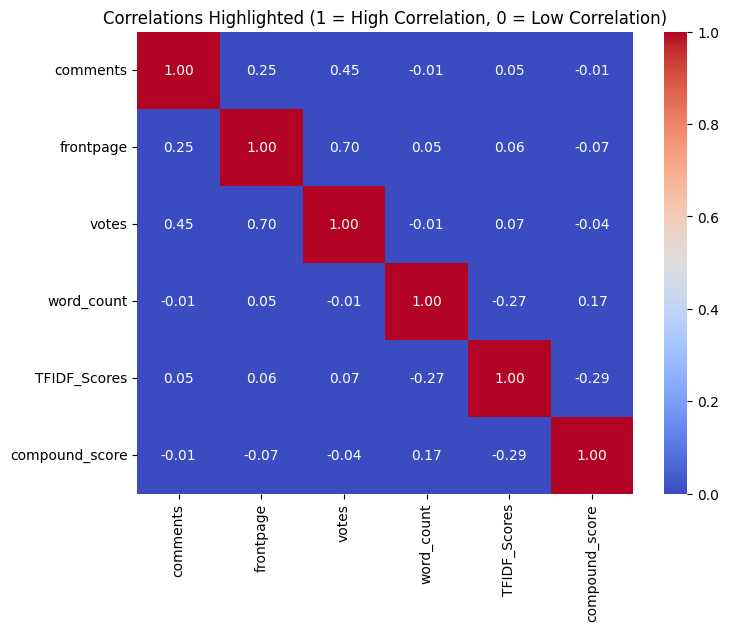

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = train_df.corr(method='pearson')

high_correlation_mask = (correlation_matrix > 0.75) | (correlation_matrix < -0.75)

plt.figure(figsize=(8, 6))
sns.heatmap(high_correlation_mask.astype(int), annot=correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.title("Correlations Highlighted (1 = High Correlation, 0 = Low Correlation)")
plt.show()

# R-Square score for the independent variables against dependent variable

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = train_df[['comments', 'votes', 'word_count', 'TFIDF_Scores', 'compound_score']]
Y = train_df['frontpage']

model = LinearRegression()
model.fit(X, Y)

Y_pred = model.predict(X)

r2 = r2_score(Y, Y_pred)

print("R-squared:", r2*100, "%")

R-squared: 49.65025204482858 %


# Model

In [75]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.pipeline import Pipeline

In [76]:
train_df = spark.createDataFrame(train_df)

test_df = spark.createDataFrame(test_df)

In [77]:
feature_cols = ["comments", "votes", "word_count", "TFIDF_Scores", "compound_score"]

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [78]:
log_reg = LogisticRegression(featuresCol="features", labelCol="frontpage")

In [79]:
pipeline = Pipeline(stages=[vector_assembler, log_reg])

In [80]:
pipeline_model = pipeline.fit(train_df)

24/05/13 15:02:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [81]:
test_predictions = pipeline_model.transform(test_df)

# Evaluation metrics

In [82]:
evaluator = BinaryClassificationEvaluator(labelCol="frontpage", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(test_predictions)

In [83]:
print("Test set AUC:", auc)

Test set AUC: 0.9831687747591947


/Users/stantschal/Desktop/spark/spark-3.5.1-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


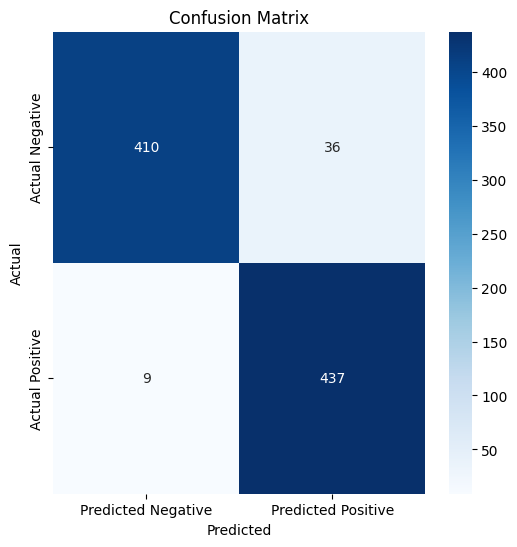

In [84]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

prediction_and_labels = test_predictions.select("prediction", "frontpage").rdd
metrics = MulticlassMetrics(prediction_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()

cm_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

plt.figure(figsize=(6, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')  # 'g' format ensures integers
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [85]:
accuracy = metrics.accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9495515695067265


In [86]:
#precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="frontpage",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(test_predictions)

# recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="frontpage",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(test_predictions)

# F1-score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="frontpage",
    predictionCol="prediction",
    metricName="f1"
)
f1 = f1_evaluator.evaluate(test_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.9512051749105643
Recall: 0.9495515695067265
F1-Score: 0.9495053054652267


# Overfitting Check

In [87]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

feature_cols = ["comments", "votes", "word_count", "TFIDF_Scores", "compound_score"]
label_col = "frontpage"  # Modify with your label column name


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)


lr = LogisticRegression(featuresCol="features", labelCol=label_col)
lr_model = lr.fit(train_df)


train_predictions = lr_model.transform(train_df)
test_predictions = lr_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")

train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

print("Training Set Accuracy:", train_accuracy)
print("Test Set Accuracy:", test_accuracy)

Training Set Accuracy: 0.9547767100056529
Test Set Accuracy: 0.9495515695067265


In [88]:

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-Fold Cross-Validation


cv_model = crossval.fit(train_df)


cv_test_predictions = cv_model.transform(test_df)
cv_test_accuracy = evaluator.evaluate(cv_test_predictions)

print("Cross-Validation Test Set Accuracy:", cv_test_accuracy)

Cross-Validation Test Set Accuracy: 0.9495515695067265


In [89]:
model_path = "/Users/stantschal/Desktop/spark/notebooks/lr_model/"

pipeline_model.write().overwrite().save(model_path)

# Predicting

In [107]:
import threading

# Helper thread to avoid the Spark StreamingContext from blocking Jupyter
        
class StreamingThread(threading.Thread):
    def __init__(self, ssc):
        super().__init__()
        self.ssc = ssc
    def run(self):
        self.ssc.start()
        self.ssc.awaitTermination()
    def stop(self):
        print('----- Stopping... this may take a few seconds -----')
        self.ssc.stop(stopSparkContext=False, stopGraceFully=True)

In [108]:
import random
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from pyspark.sql.functions import udf, struct, array, col, lit
from pyspark.sql.types import StringType

In [109]:
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml import PipelineModel

model_path = "/Users/stantschal/Desktop/spark/notebooks/lr_model/"

my_logistic_regression = PipelineModel.load(model_path)

In [110]:
globals()['models_loaded'] = False
globals()['my_model'] = None

def process(time, rdd):
    if rdd.isEmpty():
        return
    
    print("========= %s =========" % str(time))
    
    # Convert to data frame
    df = spark.read.json(rdd)

    df = df.toPandas()

    df = df.dropna()

    mask = df['source_text'].str.contains("403 Forbidden", case=False) | df['source_title'].str.contains("403 Forbidden", case=False)
    rows_to_remove = df[mask]
    df = df[~mask]

    df['is_english'] = df['title'].apply(is_english)
    df = df[df['is_english']]
    df = df.drop(columns=['is_english'])

    df['clean_source_text'] = df['source_text'].apply(clean_text)
    df['clean_source_title'] = df['title'].apply(clean_text)

    #word_count
    df['word_count'] = df['clean_source_text'].apply(count_words)

    #domain_name
    df['domain_name'] = df['domain'].apply(extract_domain)

    #TF_IDF
    df['tfidf_source_text'] = df['clean_source_text'].apply(lambda x: ' '.join(x))
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['tfidf_source_text'])
    features = tfidf_vectorizer.get_feature_names_out()
    df['TFIDF_Scores'] = [get_tfidf_dict(i) for i in range(tfidf_matrix.shape[0])]

    #sentiment
    df['clean_source_text_sentence'] = df['clean_source_text'].apply(lambda words: ' '.join(words))
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['clean_source_text_sentence'].apply(lambda sentence: analyzer.polarity_scores(sentence))
    df['compound_score'] = df['sentiment'].apply(lambda x: x['compound'])

    #drop columns
    df = df.drop(columns=['aid', 'domain', 'posted_at', 'source_text', 'source_title', 'title', 'url', 'clean_source_text', 'clean_source_title', 'tfidf_source_text', 'clean_source_text_sentence', 'sentiment'])

    #normalization
    columns_to_normalize = ['frontpage']
    scaler = MinMaxScaler()
    df = df.copy()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    df['TFIDF_Scores'] = df['TFIDF_Scores'].apply(average_tfidf)

    df = df.reset_index(drop=True)

    df = spark.createDataFrame(df)

    df.show()
    
    # Normally, you wouldn't use a UDF (User Defined Function) Python function to predict as we did here (you can)
    # but an MLlib model you've built and saved with Spark
    # In this case, you need to prevent loading your model in every call to "process" as follows:
    
    # Load in the model if not yet loaded:
    if not globals()['models_loaded']:
        # load in your models here
        globals()['my_model'] = my_logistic_regression # Replace '***' with e.g.:    [...].load('my_logistic_regression')
        globals()['models_loaded'] = True
        
    # And then predict using the loaded model (uncomment below):
    
    df_result = globals()['my_model'].transform(df)
    df_result.show()

In [111]:
ssc = StreamingContext(sc, 10)

/Users/stantschal/Desktop/spark/spark-3.5.1-bin-hadoop3/python/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


In [112]:
lines = ssc.socketTextStream("seppe.net", 7778)
lines.foreachRDD(process)

In [113]:
ssc_t = StreamingThread(ssc)
ssc_t.start()

24/05/13 15:09:29 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:29 WARN BlockManager: Block input-0-1715602169400 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:09:30 =========
+--------+---------+-------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|   user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+-------+-----+----------+-----------+--------------------+--------------+
|       0|      0.0|chadsix|    1|       206|       ipv6|0.008691586819499712|        0.6705|
+--------+---------+-------+-----+----------+-----------+--------------------+--------------+

+--------+---------+-------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|   user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|            features|       rawPrediction|         probability|prediction|
+--------+---------+-------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+------------------

24/05/13 15:09:31 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:31 WARN BlockManager: Block input-0-1715602171400 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:09:36 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:36 WARN BlockManager: Block input-0-1715602176400 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:09:40 =========
+--------+---------+----------+-----+----------+---------------+--------------------+--------------+
|comments|frontpage|      user|votes|word_count|    domain_name|        TFIDF_Scores|compound_score|
+--------+---------+----------+-----+----------+---------------+--------------------+--------------+
|       0|      0.0|    jt2190|    2|        24|         medium|0.008691586819499712|        0.8225|
|       0|      0.0|walterbell|    2|      1914|engelsbergideas|0.013419104362602173|          0.93|
+--------+---------+----------+-----+----------+---------------+--------------------+--------------+

+--------+---------+----------+-----+----------+---------------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|      user|votes|word_count|    domain_name|        TFIDF_Scores|compound_score|            features|       rawPrediction|         probability|prediction|
+--

24/05/13 15:09:40 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:40 WARN BlockManager: Block input-0-1715602180600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:09:41 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:41 WARN BlockManager: Block input-0-1715602181600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:09:45 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:45 WARN BlockManager: Block input-0-1715602185600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:09:49 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:49 WARN BlockManager: Block input-0-1715602189400 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:09:50 =========


+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|       2|      1.0|     spenvo|    6|      4519|    nytimes|0.008691586819499712|        0.9999|
|       0|      0.0|joshagilend|    2|       992|arstechnica|0.013419104362602173|        0.9886|
|       0|      0.0|theogravity|    3|         5|   engadget|  0.1362095160823194|           0.0|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+

+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|            features|       rawPrediction|  

24/05/13 15:09:52 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:52 WARN BlockManager: Block input-0-1715602192600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:09:53 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:53 WARN BlockManager: Block input-0-1715602193600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:09:55 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:09:55 WARN BlockManager: Block input-0-1715602195600 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:10:00 =========
+--------+---------+---------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|     user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+---------+-----+----------+-----------+--------------------+--------------+
|       0|      0.0|anonymfus|    1|       322|    youtube|0.008691586819499712|       -0.9526|
|       2|      1.0|   Anon84|   20|       431|        ted|0.013419104362602173|        0.9959|
|       0|      0.0|      htk|    2|       354|    youtube|  0.1362095160823194|       -0.6369|
+--------+---------+---------+-----+----------+-----------+--------------------+--------------+

+--------+---------+---------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|     user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|            features| 

24/05/13 15:10:00 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:00 WARN BlockManager: Block input-0-1715602200600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:02 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:02 WARN BlockManager: Block input-0-1715602202600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:04 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:04 WARN BlockManager: Block input-0-1715602204600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:09 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:09 WARN BlockManager: Block input-0-1715602209600 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:10:10 =========
+--------+---------+----------+-----+----------+--------------+--------------------+--------------+
|comments|frontpage|      user|votes|word_count|   domain_name|        TFIDF_Scores|compound_score|
+--------+---------+----------+-----+----------+--------------+--------------------+--------------+
|       0|      0.0|petethomas|    1|       317|washingtonpost|0.008691586819499712|        0.9793|
|       0|      0.0|  grugagag|    2|        85|       youtube|0.013419104362602173|        0.3818|
|       0|      0.0|       _kb|    2|         4|      pi-clock|  0.1362095160823194|           0.0|
+--------+---------+----------+-----+----------+--------------+--------------------+--------------+

+--------+---------+----------+-----+----------+--------------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|      user|votes|word_count|   domain_name|        TFIDF_Scores|c

24/05/13 15:10:12 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:12 WARN BlockManager: Block input-0-1715602212600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:13 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:13 WARN BlockManager: Block input-0-1715602213600 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:18 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:18 WARN BlockManager: Block input-0-1715602217800 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:10:20 =========
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|       0|      0.0|  ipster_io|    2|       391|  hypermink|0.008691586819499712|        0.9948|
|       2|      0.0|thisislife2|    1|      1557| indiatimes|0.013419104362602173|        0.9992|
|       0|      0.0|  peterb0yd|    2|       108| foodlogger|  0.1362095160823194|        0.9786|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+

+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|    

24/05/13 15:10:23 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:23 WARN BlockManager: Block input-0-1715602222800 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:27 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:27 WARN BlockManager: Block input-0-1715602226800 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:10:30 =========


+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|       0|      0.0|wahnfrieden|    1|      2796|     apnews|0.008691586819499712|       -0.9983|
|       0|      0.0|   peutetre|    1|      1199|   newatlas|0.013419104362602173|        0.9989|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+

+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|            features|       rawPrediction|         probability|prediction|
+--------+---------+-----------+-----+----------+-----------+------

24/05/13 15:10:32 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:32 WARN BlockManager: Block input-0-1715602231800 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:34 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:34 WARN BlockManager: Block input-0-1715602233800 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:39 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:39 WARN BlockManager: Block input-0-1715602238800 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:10:40 =========
+--------+---------+-------------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|         user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+-------------+-----+----------+-----------+--------------------+--------------+
|       0|      0.0|    hanson108|    1|       649|         un|0.008691586819499712|       -0.9882|
|       0|      0.0|    nateb2022|    1|       410|     github|0.013419104362602173|        0.9936|
|       0|      0.0|kixpanganiban|    1|       102|    youtube|  0.1362095160823194|         0.765|
+--------+---------+-------------+-----+----------+-----------+--------------------+--------------+

+--------+---------+-------------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|         user|votes|word_count|domain_name|        TFIDF_Scores|c

24/05/13 15:10:43 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:43 WARN BlockManager: Block input-0-1715602242800 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:48 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:48 WARN BlockManager: Block input-0-1715602248000 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:50 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:50 WARN BlockManager: Block input-0-1715602249800 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:10:50 =========


+--------+---------+-------+-----+----------+------------------+--------------------+--------------+
|comments|frontpage|   user|votes|word_count|       domain_name|        TFIDF_Scores|compound_score|
+--------+---------+-------+-----+----------+------------------+--------------------+--------------+
|       0|      0.0|mooreds|    1|      1356|             slate|0.008691586819499712|        0.9991|
|       0|      0.0|mooreds|    1|      3115|everybodyinthepool|0.013419104362602173|           1.0|
+--------+---------+-------+-----+----------+------------------+--------------------+--------------+

+--------+---------+-------+-----+----------+------------------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|   user|votes|word_count|       domain_name|        TFIDF_Scores|compound_score|            features|       rawPrediction|         probability|prediction|
+--------+---------+-------+-----+---------

24/05/13 15:10:51 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:51 WARN BlockManager: Block input-0-1715602251000 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:55 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:55 WARN BlockManager: Block input-0-1715602255000 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:10:56 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:10:56 WARN BlockManager: Block input-0-1715602256000 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:00 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:00 WARN BlockManager: Block input-0-1715602260000 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:11:00 =========
+--------+---------+---------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|     user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+---------+-----+----------+-----------+--------------------+--------------+
|       0|      0.0| peutetre|    1|       875|   newatlas|0.008691586819499712|         0.999|
|       0|      0.0|  mooreds|    1|      1434|     rubrik|0.013419104362602173|        0.9994|
|       0|      0.0|  testrun|    1|        64|        com|  0.1362095160823194|        0.7783|
|       0|      0.0|PaulHoule|    1|       411|      arxiv|0.023534489399530217|        0.9957|
+--------+---------+---------+-----+----------+-----------+--------------------+--------------+

+--------+---------+---------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage| 

24/05/13 15:11:03 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:03 WARN BlockManager: Block input-0-1715602263000 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:04 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:04 WARN BlockManager: Block input-0-1715602264000 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:08 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:08 WARN BlockManager: Block input-0-1715602268000 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:11:10 =========
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|       6|      0.0|perihelions|   12|       428|theguardian|0.008691586819499712|       -0.8512|
|       0|      0.0|  chris1993|    9|      1205|        net|0.013419104362602173|        0.8625|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+

+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|            features|       rawPrediction|         probability|prediction|
+--------+---------+-------

24/05/13 15:11:12 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:12 WARN BlockManager: Block input-0-1715602272200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:16 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:16 WARN BlockManager: Block input-0-1715602276000 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:18 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:18 WARN BlockManager: Block input-0-1715602278000 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:19 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:19 WARN BlockManager: Block input-0-1715602279000 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:11:20 =========
+--------+---------+----------+-----+----------+-------------+--------------------+--------------+
|comments|frontpage|      user|votes|word_count|  domain_name|        TFIDF_Scores|compound_score|
+--------+---------+----------+-----+----------+-------------+--------------------+--------------+
|      13|      1.0|aurareturn|   15|       285|    geekbench|0.008691586819499712|        0.4019|
|       3|      1.0|    packjc|    9|       360|       github|0.013419104362602173|        0.9922|
|       4|      1.0|  grugagag|    4|        72|      youtube|  0.1362095160823194|        0.4215|
|       0|      0.0|  qzervaas|    2|      1039|flightradar24|0.023534489399530217|        0.9995|
+--------+---------+----------+-----+----------+-------------+--------------------+--------------+

+--------+---------+----------+-----+----------+-------------+--------------------+--------------+--------------------+--------------------+--------------------+------

24/05/13 15:11:23 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:23 WARN BlockManager: Block input-0-1715602283200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:26 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:26 WARN BlockManager: Block input-0-1715602286200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:28 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:28 WARN BlockManager: Block input-0-1715602288200 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:11:30 =========


24/05/13 15:11:30 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:30 WARN BlockManager: Block input-0-1715602290200 replicated to only 0 peer(s) instead of 1 peers


+--------+---------+------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|  user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+------+-----+----------+-----------+--------------------+--------------+
|       0|      0.0|Paulvu|    1|       439|      apple|0.008691586819499712|        0.9983|
|       0|      0.0| rolph|    1|        24|techatpower|0.013419104362602173|        0.8225|
|       0|      0.0| rolph|    1|      1422| resecurity|  0.1362095160823194|       -0.9464|
+--------+---------+------+-----+----------+-----------+--------------------+--------------+

+--------+---------+------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|  user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|            features|       rawPrediction|         probability|prediction|
+--------+----

24/05/13 15:11:31 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:31 WARN BlockManager: Block input-0-1715602291200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:34 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:34 WARN BlockManager: Block input-0-1715602294200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:38 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:38 WARN BlockManager: Block input-0-1715602298200 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:11:40 =========
+--------+---------+----------+-----+----------+---------------+--------------------+--------------+
|comments|frontpage|      user|votes|word_count|    domain_name|        TFIDF_Scores|compound_score|
+--------+---------+----------+-----+----------+---------------+--------------------+--------------+
|       0|      0.0|    sak5sk|    1|        22|         satcom|0.008691586819499712|        0.1779|
|       0|      0.0|loongloong|    1|       623|thebadgeronline|0.013419104362602173|        0.9882|
|       0|      0.0|   gshakir|    1|       388|         github|  0.1362095160823194|        0.9738|
|       0|      1.0|     rolph|    3|      1144|            gnu|0.023534489399530217|         0.999|
+--------+---------+----------+-----+----------+---------------+--------------------+--------------+

+--------+---------+----------+-----+----------+---------------+--------------------+--------------+--------------------+--------------------+---------

24/05/13 15:11:43 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:43 WARN BlockManager: Block input-0-1715602303200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:46 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:46 WARN BlockManager: Block input-0-1715602306200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:48 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:48 WARN BlockManager: Block input-0-1715602308200 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:11:50 =========


24/05/13 15:11:50 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:50 WARN BlockManager: Block input-0-1715602310400 replicated to only 0 peer(s) instead of 1 peers


+--------+---------+----------+-----+----------+--------------+--------------------+--------------+
|comments|frontpage|      user|votes|word_count|   domain_name|        TFIDF_Scores|compound_score|
+--------+---------+----------+-----+----------+--------------+--------------------+--------------+
|       0|      0.0|ghostdogpr|    1|      1238|pierre-ricadat|0.008691586819499712|        0.9969|
|       0|      1.0|meysamazad|    7|      1435|       shuttle|0.013419104362602173|        0.9992|
|       0|      0.0| FillMaths|    2|      1702|infinitelymore|  0.1362095160823194|        0.9988|
+--------+---------+----------+-----+----------+--------------+--------------------+--------------+

+--------+---------+----------+-----+----------+--------------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|comments|frontpage|      user|votes|word_count|   domain_name|        TFIDF_Scores|compound_score|            features|     

24/05/13 15:11:53 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:53 WARN BlockManager: Block input-0-1715602313200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:54 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:54 WARN BlockManager: Block input-0-1715602314200 replicated to only 0 peer(s) instead of 1 peers
24/05/13 15:11:57 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
24/05/13 15:11:57 WARN BlockManager: Block input-0-1715602317400 replicated to only 0 peer(s) instead of 1 peers


========= 2024-05-13 15:12:00 =========
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|comments|frontpage|       user|votes|word_count|domain_name|        TFIDF_Scores|compound_score|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+
|       0|      0.0|thunderbong|    1|       657|     github|0.008691586819499712|        0.9894|
|       0|      0.0|    mooreds|    1|       457|  typesense|0.013419104362602173|        0.9817|
|       0|      0.0|   RafelMri|    1|      1157|  aljazeera|  0.1362095160823194|        0.9965|
|       0|      0.0|thunderbong|    1|      1547|   blogspot|0.023534489399530217|        0.9818|
+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+

+--------+---------+-----------+-----+----------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+----------+
|co

In [114]:
ssc_t.stop()

----- Stopping... this may take a few seconds -----


24/05/13 15:12:29 ERROR ReceiverTracker: Deregistered receiver for stream 0: Stopped by driver
24/05/13 15:12:29 WARN SocketReceiver: Error receiving data
java.net.SocketException: Socket closed
	at java.base/java.net.SocketInputStream.socketRead0(Native Method)
	at java.base/java.net.SocketInputStream.socketRead(SocketInputStream.java:115)
	at java.base/java.net.SocketInputStream.read(SocketInputStream.java:168)
	at java.base/java.net.SocketInputStream.read(SocketInputStream.java:140)
	at java.base/sun.nio.cs.StreamDecoder.readBytes(StreamDecoder.java:284)
	at java.base/sun.nio.cs.StreamDecoder.implRead(StreamDecoder.java:326)
	at java.base/sun.nio.cs.StreamDecoder.read(StreamDecoder.java:178)
	at java.base/java.io.InputStreamReader.read(InputStreamReader.java:181)
	at java.base/java.io.BufferedReader.fill(BufferedReader.java:161)
	at java.base/java.io.BufferedReader.readLine(BufferedReader.java:326)
	at java.base/java.io.BufferedReader.readLine(BufferedReader.java:392)
	at org.apache